In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from perturbed_organics.spectrum_general import sim_solution
import perturbed_organics.model.ORGaNICs_models as organics
import perturbed_organics.utils as utils
import matplotlib.ticker as ticker
import os

# Set default dtype for torch
torch.set_default_dtype(torch.float64)


In [10]:
# Define simulation parameters
N = 100
params = {"N_y": N, "N_a": N, "eta": 0.02, "noise_type": "additive"}
b0 = torch.ones(N)
b1 = torch.ones(N)
sigma = torch.tensor([0.1])
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
# Wyy = torch.eye(N)
Way = torch.ones(N, N)

In [47]:
# Specify delta and generate Wyy
mu = 0.0
delta = 0.3  # Adjust delta as desired

In [48]:
# Define the time vector for simulation
tau_min = min(torch.min(tauA), torch.min(tauY))
tau_max = max(torch.max(tauA), torch.max(tauY))
chunk_time = 500 * tau_max  
dt = 0.05 * tau_min
points = int(chunk_time / dt)
t_chunk = torch.linspace(0, chunk_time, points)

In [49]:
# Model setup
model_name = 'delocalized'
input_norm = 0.01
initial_type = 'zero'

z = utils.make_input_drive(N=N, input_type=model_name, input_norm=input_norm)

### Trajectory of the first y neurons across trials

In [6]:
n_trajectories = 5  # Desired number of accepted trajectories
idx = 0           # Index of the state variable to check
threshold = 0.03   # Define your threshold here

trajectories_idx = []  # List to store accepted trajectory data

accepted = 0  # Counter for accepted trajectories
while accepted < n_trajectories:
    Wyy = torch.eye(N) + utils.generate_matrix(N=N, matrix_type='goe_symmetric', s=N, mu=mu, delta=delta)
    model = organics.ORGaNICs2DgeneralRectifiedRecurrence(
        params=params,
        b0=b0,
        b1=b1,
        sigma=sigma,
        tauA=tauA,
        tauY=tauY,
        Wyy=Wyy,
        Way=Way,
        z=z,
        initial_type=initial_type,
        run_jacobian=False,
    )
    sim_obj = sim_solution(model)
    # Each trajectory uses a fresh initial condition
    y0 = model.inital_conditions(initial_type=initial_type)
    traj = sim_obj.simulate(t_chunk, y0=y0)
    
    # Check the final value of the state variable at the specified index
    final_value = traj[-1, idx].detach().numpy()
    if final_value < threshold:
        # Trajectory rejected because its final value is below the threshold
        continue
    else:
        # Store the accepted trajectory data
        trajectories_idx.append(traj[:, idx].detach().numpy())
        accepted += 1


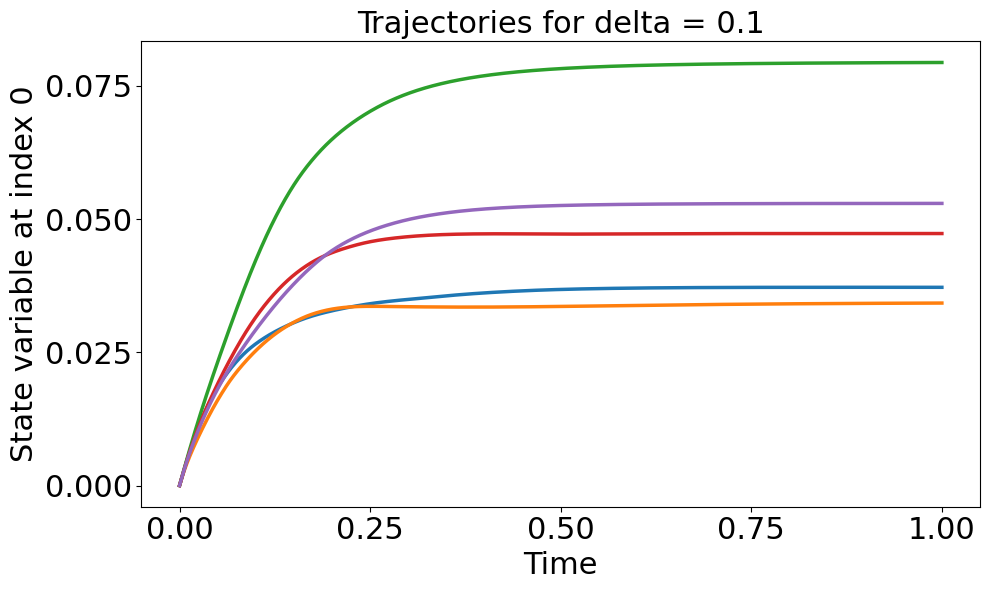

In [7]:

# Now, plot the stored trajectories on a single figure
plt.figure(figsize=(10, 6))
colors = plt.get_cmap("tab10")

for i, traj_data in enumerate(trajectories_idx):
    plt.plot(t_chunk.numpy(), traj_data, linewidth=2.5, label=f'Trajectory {i+1}', color=colors(i))

# Set labels and title with the same font sizes as before
plt.xlabel("Time", fontsize=22)
plt.ylabel(f"State variable at index {idx}", fontsize=22)
plt.title(f"Trajectories for delta = {delta}", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# Limit to only 4 ticks on x axis
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))

# plt.legend(fontsize=12)

# Create folder and file save paths similar to the histogram code
folder_loc = f'../figures/mu_{mu}/fig_trajectories'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'trajectories_{delta}'
file_save_path = os.path.join(folder_loc, file_name)

plt.tight_layout()
plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


### Trajectory of all the neurons for a given trial

In [55]:
# Single trial simulation for all neurons
Wyy = torch.eye(N) + utils.generate_matrix(N=N, matrix_type='goe_symmetric', s=N, mu=mu, delta=delta)
model = organics.ORGaNICs2DgeneralRectifiedRecurrence(
    params=params,
    b0=b0,
    b1=b1,
    sigma=sigma,
    tauA=tauA,
    tauY=tauY,
    Wyy=Wyy,
    Way=Way,
    z=z,
    initial_type=initial_type,
    run_jacobian=False,
)
sim_obj = sim_solution(model)
# Use a fresh initial condition for the trial
y0 = model.inital_conditions(initial_type=initial_type)
traj = sim_obj.simulate(t_chunk, y0=y0)

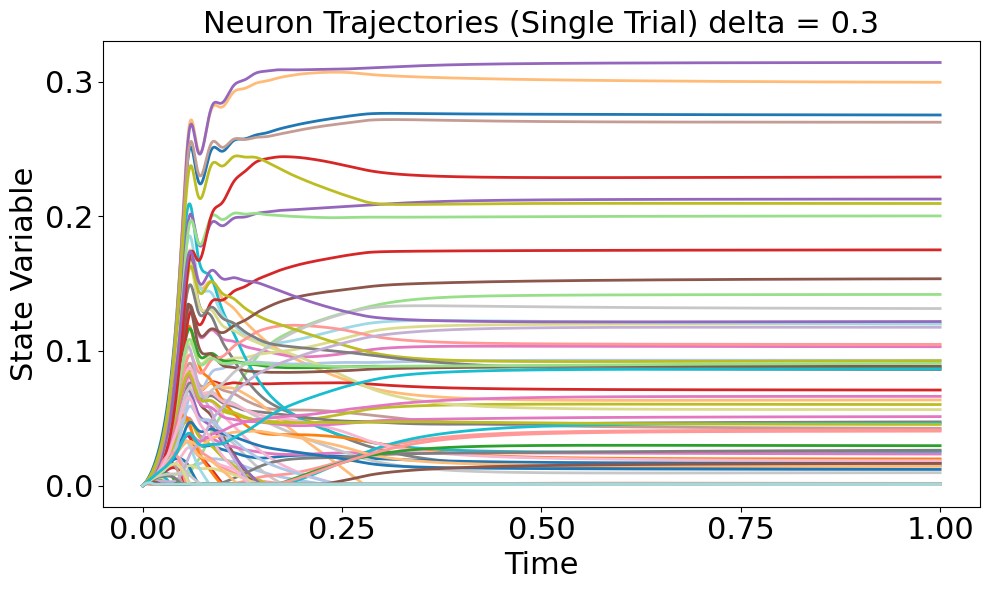

In [61]:

# Plot trajectories for all neurons on the same figure
plt.figure(figsize=(10, 6))
colors = plt.get_cmap("tab20")

for neuron in range(N):
    # Cycle through colors if N > 10
    plt.plot(t_chunk.numpy(), traj[:, neuron].detach().numpy(), linewidth=2.0,
             label=f'Neuron {neuron}', color=colors(neuron % 20))

plt.xlabel("Time", fontsize=22)
plt.ylabel("State Variable", fontsize=22)
plt.title(f"Neuron Trajectories (Single Trial) delta = {delta}", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# Limit number of ticks for clarity
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))

plt.tight_layout()

# Save the figure (adjust the folder and file names as needed)
folder_loc = f'../figures/mu_{mu}/fig_neuron_trajectories'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'neuron_trajectories_single_trial_{delta}'
file_save_path = os.path.join(folder_loc, file_name)

plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()


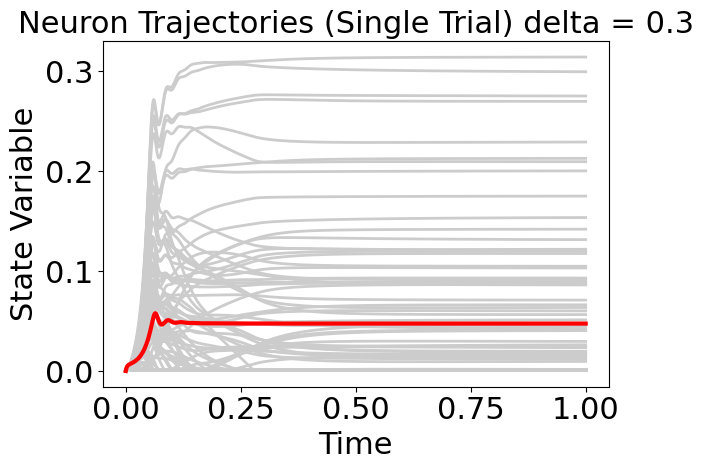

In [60]:
for neuron in range(N):
    plt.plot(t_chunk.numpy(), traj[:, neuron].detach().numpy(), linewidth=2.0,
             label=f'Neuron {neuron}', color="0.8")

# Compute the L2 norm across neurons for each time point and plot in red
# (Assumes traj is a 2D tensor with shape [time, neurons])
avg_traj = torch.mean(traj, dim=1)
plt.plot(t_chunk.numpy(), avg_traj.detach().numpy(), linewidth=3.0, color="red", label='Norm')

plt.xlabel("Time", fontsize=22)
plt.ylabel("State Variable", fontsize=22)
plt.title(f"Neuron Trajectories (Single Trial) delta = {delta}", fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# Limit number of ticks for clarity
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))

plt.tight_layout()

# Save the figure (adjust the folder and file names as needed)
folder_loc = f'../figures/mu_{mu}/fig_neuron_trajectories'
os.makedirs(folder_loc, exist_ok=True)
file_name = f'neuron_trajectories_single_trial_{delta}'
file_save_path = os.path.join(folder_loc, file_name)

plt.savefig(f'{file_save_path}.png', bbox_inches='tight')
plt.savefig(f'{file_save_path}.svg', format='svg', bbox_inches='tight', dpi=300)
plt.savefig(f'{file_save_path}.eps', format='eps', bbox_inches='tight', dpi=300)
plt.show()